# K2 Exoplanet Detection - Complete Machine Learning Pipeline v6

This notebook creates a comprehensive machine learning pipeline for exoplanet detection using the K2 dataset.

## Project Objective
Using the K2 dataset to develop a 3-class classification model:
- **Candidate**: Planet candidates
- **Confirmed**: Confirmed planets  
- **False_Positive**: False positives

## Pipeline Steps
1. **Data Loading and Exploratory Data Analysis**
2. **Data Preprocessing and Cleaning**
3. **Feature Engineering**
4. **Model Development and Training**
5. **Model Evaluation and Optimization**
6. **Results Analysis**

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# XGBoost and LightGBM
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. To install: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not installed. To install: pip install lightgbm")

# Graphics settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Libraries loaded successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")

Libraries loaded successfully!
XGBoost available: True
LightGBM available: True


## 1. Data Loading and Initial Exploratory Analysis

In [18]:
# Load K2 dataset
data_path = "../k2/k2.csv"
df = pd.read_csv(data_path)

print("=== K2 Dataset General Information ===")
print(f"Dataset size: {df.shape}")
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\n=== First 5 rows ===")
df.head()

=== K2 Dataset General Information ===
Dataset size: (4004, 295)
Number of columns: 295
Number of rows: 4004

=== First 5 rows ===


,rowid,pl_name,hostname,pl_letter,k2_name,epic_hostname,epic_candname,hd_name,hip_name,tic_id,...,releasedate,pl_nnotes,k2_campaigns,k2_campaigns_num,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2018-02-15,1,4,1.0,0,0,0,0,0,0
1,2,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2016-07-28,1,4,1.0,0,0,0,0,0,0
2,3,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2018-04-26,1,4,1.0,0,0,0,0,0,0
3,4,EPIC 201111557.01,EPIC 201111557,NaN,NaN,EPIC 201111557,EPIC 201111557.01,NaN,NaN,TIC 176942156,...,2018-08-02,0,10,1.0,0,0,0,0,0,0
4,5,EPIC 201111557.01,EPIC 201111557,NaN,NaN,EPIC 201111557,EPIC 201111557.01,NaN,NaN,TIC 176942156,...,2018-02-15,0,10,1.0,0,0,0,0,0,0


In [19]:
# Dataset information
print("=== Data Types ===")
print(df.dtypes.value_counts())
print(f"\nNumerical columns: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"Categorical columns: {df.select_dtypes(include=['object']).shape[1]}")

print("\n=== Missing Values Analysis ===")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)

print("Columns with most missing values:")
print(missing_info[missing_info['Missing_Count'] > 0].head(10))

=== Data Types ===
float64    236
object      33
int64       26
Name: count, dtype: int64

Numerical columns: 262
Categorical columns: 33

=== Missing Values Analysis ===
Columns with most missing values:
                  Missing_Count  Missing_Percentage
sy_icmagerr1               4004          100.000000
pl_occdeperr2              4004          100.000000
pl_occdeperr1              4004          100.000000
sy_icmagerr2               4004          100.000000
sy_kepmagerr1              4004          100.000000
sy_kepmagerr2              4004          100.000000
sy_icmag                   4004          100.000000
pl_occdeplim               4003           99.975025
pl_occdep                  4003           99.975025
pl_trueobliqerr1           3994           99.750250


=== Target Variable Analysis (disposition) ===
Class distribution:
disposition
CONFIRMED         2315
CANDIDATE         1374
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64

Total number of classes: 4
Most common class: CONFIRMED (2315 samples)


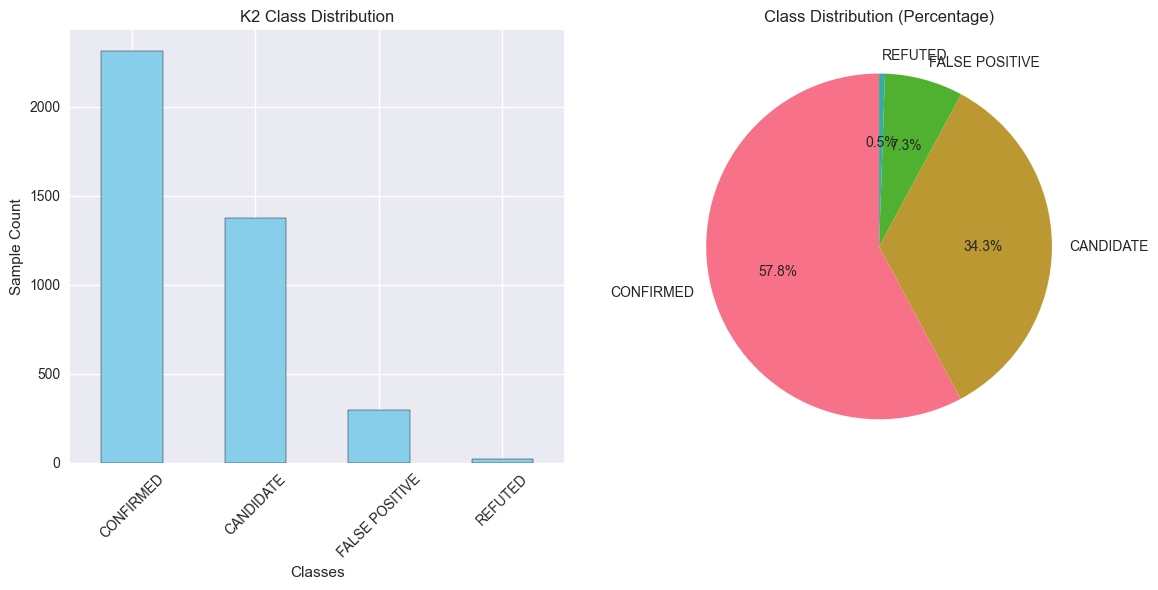


Class descriptions:
CONFIRMED: Confirmed planets
CANDIDATE: Planet candidates
FALSE POSITIVE: False positives


In [20]:
# Target variable analysis (disposition column)
print("=== Target Variable Analysis (disposition) ===")
print("Class distribution:")
class_counts = df['disposition'].value_counts()
print(class_counts)

print(f"\nTotal number of classes: {len(class_counts)}")
print(f"Most common class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")

# Visualization of class distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('K2 Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print("\nClass descriptions:")
print("CONFIRMED: Confirmed planets")
print("CANDIDATE: Planet candidates") 
print("FALSE POSITIVE: False positives")

## 2. Data Preprocessing and Cleaning

In [21]:
# Create 3-class target variable
def create_3class_target(disposition_value):
    """
    Converts K2 disposition values to 3 classes:
    - Candidate (0): CANDIDATE - Planet candidates
    - Confirmed (1): CONFIRMED - Confirmed planets
    - False_Positive (2): FALSE POSITIVE, REFUTED - False positives and refuted candidates
    """
    if disposition_value == 'CANDIDATE':
        return 0  # Candidate
    elif disposition_value == 'CONFIRMED':
        return 1  # Confirmed
    elif disposition_value in ['FALSE POSITIVE', 'REFUTED']:
        return 2  # False_Positive
    else:
        return -1  # Unknown

# Create 3-class target variable
df['target_3class'] = df['disposition'].apply(create_3class_target)

# Remove unknown classes
unknown_mask = df['target_3class'] == -1
print(f"Samples with unknown class: {unknown_mask.sum()}")

if unknown_mask.sum() > 0:
    print("Unknown classes:")
    print(df[unknown_mask]['disposition'].value_counts())
    
df_clean = df[df['target_3class'] != -1].copy()

print(f"\nCleaned dataset size: {df_clean.shape}")
print("\n3-class target variable distribution:")
target_counts = df_clean['target_3class'].value_counts().sort_index()
target_names = ['Candidate', 'Confirmed', 'False_Positive']
for i, (count, name) in enumerate(zip(target_counts, target_names)):
    print(f"{i} - {name}: {count} samples ({count/len(df_clean)*100:.1f}%)")

Samples with unknown class: 0

Cleaned dataset size: (4004, 296)

3-class target variable distribution:
0 - Candidate: 1374 samples (34.3%)
1 - Confirmed: 2315 samples (57.8%)
2 - False_Positive: 315 samples (7.9%)


In [22]:
# Feature selection and cleaning
print("=== Feature Selection ===")

# Define columns to exclude
exclude_columns = [
    'rowid', 'disposition', 'target_3class', 'default_flag',  # Target and ID columns
    'pl_name', 'hostname', 'pl_letter', 'k2_name', 'epic_hostname', 'epic_candname', # Name columns
    'hd_name', 'hip_name', 'tic_id', 'gaia_id', 'disp_refname', 'disc_refname',  # ID columns
    'disc_pubdate', 'disc_locale', 'disc_facility', 'disc_telescope', 'disc_instrument', # Discovery info
    'st_refname', 'sy_refname', 'rastr', 'decstr', 'rowupdate', 'pl_pubdate', 'releasedate', # Reference columns
    'pl_refname', 'st_spectype', 'ttv_flag', 'rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag', # Flag columns
    'ast_flag', 'obm_flag', 'micro_flag', 'etv_flag', 'ima_flag', 'dkin_flag', 'cb_flag', # Flag columns
    'pl_controv_flag', 'soltype', 'pl_bmassprov', 'pl_tsystemref', 'st_metratio' # Additional flags
]

# Select numerical features
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
feature_columns = [col for col in numerical_columns if col not in exclude_columns]

print(f"Total numerical columns: {len(numerical_columns)}")
print(f"Number of features to use: {len(feature_columns)}")
print(f"Number of excluded columns: {len(exclude_columns)}")

# Create feature matrix
X = df_clean[feature_columns].copy()
y = df_clean['target_3class'].copy()

print(f"\nFeature matrix size: {X.shape}")
print(f"Target variable size: {y.shape}")

# Show used features
print(f"\nUsed features ({len(feature_columns)} total):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")
    if i % 5 == 0:  # Empty line after every 5 features
        print()

=== Feature Selection ===
Total numerical columns: 263
Number of features to use: 247
Number of excluded columns: 47

Feature matrix size: (4004, 247)
Target variable size: (4004,)

Used features (247 total):
 1. sy_snum
 2. sy_pnum
 3. sy_mnum
 4. disc_year
 5. pl_orbper

 6. pl_orbpererr1
 7. pl_orbpererr2
 8. pl_orbperlim
 9. pl_orbsmax
10. pl_orbsmaxerr1

11. pl_orbsmaxerr2
12. pl_orbsmaxlim
13. pl_rade
14. pl_radeerr1
15. pl_radeerr2

16. pl_radelim
17. pl_radj
18. pl_radjerr1
19. pl_radjerr2
20. pl_radjlim

21. pl_masse
22. pl_masseerr1
23. pl_masseerr2
24. pl_masselim
25. pl_massj

26. pl_massjerr1
27. pl_massjerr2
28. pl_massjlim
29. pl_msinie
30. pl_msinieerr1

31. pl_msinieerr2
32. pl_msinielim
33. pl_msinij
34. pl_msinijerr1
35. pl_msinijerr2

36. pl_msinijlim
37. pl_cmasse
38. pl_cmasseerr1
39. pl_cmasseerr2
40. pl_cmasselim

41. pl_cmassj
42. pl_cmassjerr1
43. pl_cmassjerr2
44. pl_cmassjlim
45. pl_bmasse

46. pl_bmasseerr1
47. pl_bmasseerr2
48. pl_bmasselim
49. pl_bmassj
5

In [23]:
# Missing value analysis and processing
print("=== Missing Value Processing ===")

missing_info = X.isnull().sum()
missing_features = missing_info[missing_info > 0].sort_values(ascending=False)

print(f"Number of features with missing values: {len(missing_features)}")
print(f"Total number of missing values: {missing_info.sum()}")

if len(missing_features) > 0:
    print("\nFeatures with most missing values:")
    for feature, count in missing_features.head(10).items():
        percentage = (count / len(X)) * 100
        print(f"{feature}: {count} ({percentage:.1f}%)")

    # Remove features with too many missing values (>25% missing)
    high_missing_threshold = 0.25
    high_missing_features = missing_features[missing_features / len(X) > high_missing_threshold].index.tolist()
    
    if len(high_missing_features) > 0:
        print(f"\nRemoving features with >{high_missing_threshold*100}% missing values:")
        print(high_missing_features)
        X = X.drop(columns=high_missing_features)
        
    print(f"\nNumber of features after processing: {X.shape[1]}")

# Fill remaining missing values
if X.isnull().sum().sum() > 0:
    print("\nRemaining missing values will be filled with median...")
    imputer = SimpleImputer(strategy='median')
    X_filled = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    print(f"Total missing values after processing: {X_filled.isnull().sum().sum()}")
    X = X_filled
else:
    print("No missing values found.")

=== Missing Value Processing ===
Number of features with missing values: 230
Total number of missing values: 528171

Features with most missing values:
pl_occdeperr1: 4004 (100.0%)
sy_icmag: 4004 (100.0%)
sy_kepmagerr2: 4004 (100.0%)
sy_icmagerr1: 4004 (100.0%)
sy_icmagerr2: 4004 (100.0%)
sy_kepmagerr1: 4004 (100.0%)
pl_occdeperr2: 4004 (100.0%)
pl_occdeplim: 4003 (100.0%)
pl_occdep: 4003 (100.0%)
pl_trueobliqerr2: 3994 (99.8%)

Removing features with >25.0% missing values:
['pl_occdeperr1', 'sy_icmag', 'sy_kepmagerr2', 'sy_icmagerr1', 'sy_icmagerr2', 'sy_kepmagerr1', 'pl_occdeperr2', 'pl_occdeplim', 'pl_occdep', 'pl_trueobliqerr2', 'pl_trueobliqerr1', 'pl_trueobliq', 'pl_trueobliqlim', 'pl_cmassjlim', 'pl_cmassjerr2', 'pl_cmassjerr1', 'pl_cmassj', 'pl_cmasselim', 'pl_cmasseerr2', 'pl_cmasseerr1', 'pl_cmasse', 'pl_orbtpererr1', 'pl_orbtpererr2', 'pl_projobliqerr2', 'pl_projobliqerr1', 'pl_msinijerr1', 'pl_msinijerr2', 'pl_orbtper', 'pl_msinijlim', 'pl_orbtperlim', 'pl_msinij', 'pl_msin

## 3. Exploratory Data Analysis and Visualization

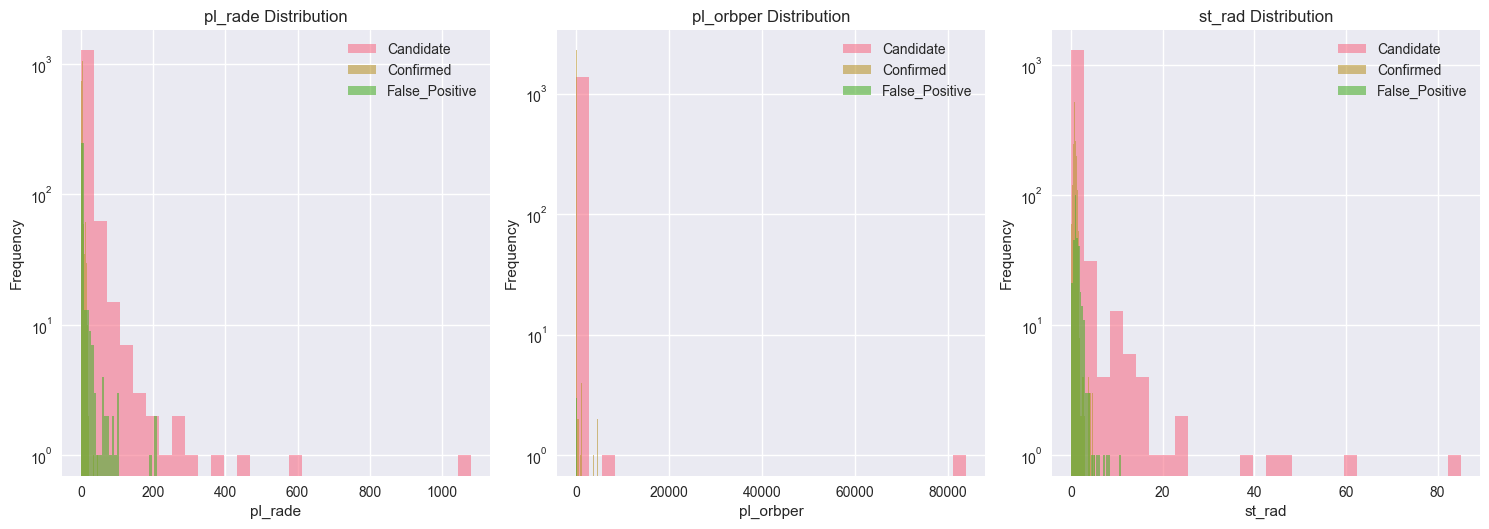

In [24]:
# Analyze distribution of important features for K2 dataset
# K2 dataset'inde planet ve stellar özellikleri önemli
important_features = ['pl_rade', 'pl_orbper', 'pl_masse', 'pl_trandep', 'pl_trandur', 'st_teff', 'st_rad', 'st_mass']
available_features = [feat for feat in important_features if feat in X.columns]

if len(available_features) > 0:
    plt.figure(figsize=(15, 10))
    target_names = ['Candidate', 'Confirmed', 'False_Positive']
    
    for i, feature in enumerate(available_features[:6], 1):
        plt.subplot(2, 3, i)
        
        for target_class in range(3):
            mask = y == target_class
            if mask.sum() > 0:
                data = X.loc[mask, feature].dropna()
                if len(data) > 0:
                    plt.hist(data, alpha=0.6, label=target_names[target_class], bins=30)
        
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'{feature} Distribution')
        plt.legend()
        plt.yscale('log')  # Use log scale
    
    plt.tight_layout()
    plt.show()

else:    print("No important features found for visualization.")

=== Correlation Analysis ===
Number of feature pairs with correlation > 0.9: 61

Highly correlated feature pairs:
pl_orbper - pl_orbpererr1: 0.998
pl_orbper - pl_orbpererr2: -0.999
pl_orbpererr1 - pl_orbpererr2: -0.996
pl_rade - pl_radj: 1.000
pl_radelim - pl_radjlim: 1.000
pl_tranmiderr1 - pl_tranmiderr2: -0.989
ra - elon: 1.000
sy_pmerr1 - sy_pmerr2: -1.000
sy_pmerr1 - sy_pmraerr1: 1.000
sy_pmerr1 - sy_pmraerr2: -1.000


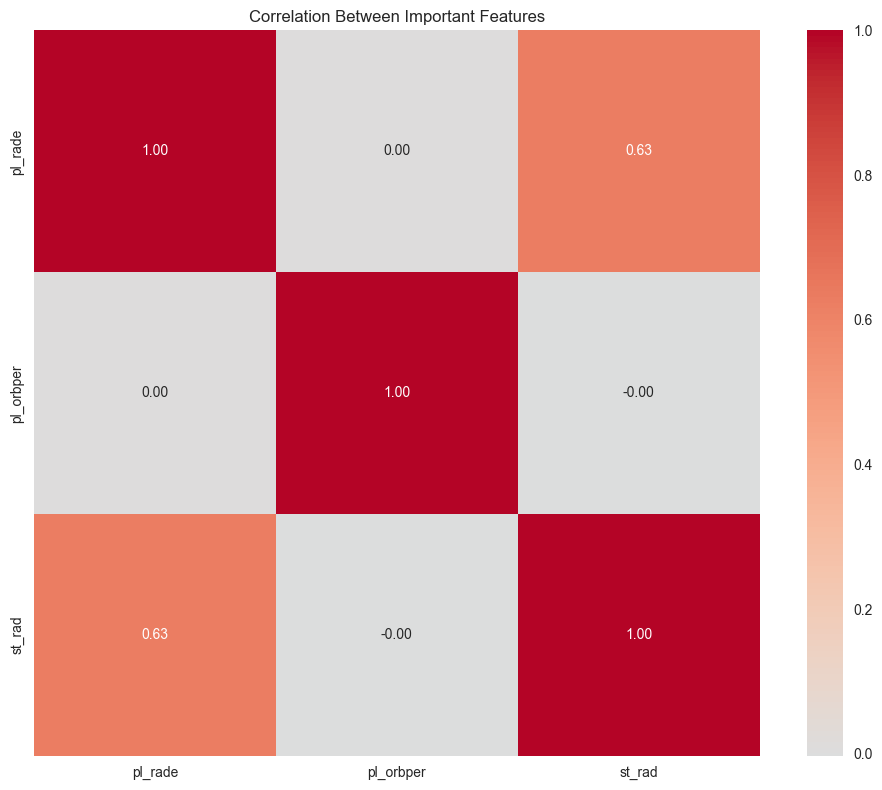

In [25]:
# Correlation analysis
print("=== Correlation Analysis ===")

# Calculate correlation of numerical features
correlation_matrix = X.corr()

# Find highly correlated feature pairs
def find_high_correlation_pairs(corr_matrix, threshold=0.9):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_matrix.iloc[i, j]
                ))
    return high_corr_pairs

high_corr = find_high_correlation_pairs(correlation_matrix, 0.9)
print(f"Number of feature pairs with correlation > 0.9: {len(high_corr)}")

if len(high_corr) > 0:
    print("\nHighly correlated feature pairs:")
    for feat1, feat2, corr_val in high_corr[:10]:  # Show first 10 pairs
        print(f"{feat1} - {feat2}: {corr_val:.3f}")

# Visualize most important correlations (only important features)
if len(available_features) > 1:
    available_corr = correlation_matrix.loc[available_features, available_features]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(available_corr, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Correlation Between Important Features')
    plt.tight_layout()
    plt.show()

## 4. Feature Engineering and Selection

In [26]:
# Remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.95):
    """Removes one of the highly correlated features."""
    corr_matrix = X.corr().abs()
    
    # Get upper triangle
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find highly correlated features
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    return X.drop(columns=to_drop), to_drop

X_reduced, dropped_features = remove_highly_correlated_features(X, threshold=0.95)
print(f"Number of features removed due to high correlation: {len(dropped_features)}")
print(f"Remaining number of features: {X_reduced.shape[1]}")

if len(dropped_features) > 0:
    print("Removed features:")
    for feature in dropped_features:
        print(f"- {feature}")

X = X_reduced

Number of features removed due to high correlation: 31
Remaining number of features: 52
Removed features:
- pl_orbpererr1
- pl_orbpererr2
- pl_radj
- pl_radjlim
- pl_tranmiderr2
- elon
- sy_pmerr2
- sy_pmraerr1
- sy_pmraerr2
- sy_pmdecerr1
- sy_pmdecerr2
- sy_disterr2
- sy_plxerr2
- sy_bmagerr2
- sy_vmagerr2
- sy_jmagerr2
- sy_hmag
- sy_hmagerr2
- sy_kmag
- sy_kmagerr2
- sy_w1mag
- sy_w1magerr2
- sy_w2mag
- sy_w2magerr2
- sy_w3mag
- sy_w3magerr2
- sy_gaiamag
- sy_gaiamagerr2
- sy_tmag
- sy_tmagerr2
- sy_kepmag


In [27]:
# Statistical feature selection
print("=== Statistical Feature Selection ===")

# Select best k features with F-score
k_best = min(20, X.shape[1])  # Select at most 20 features
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X, y)

# Get names of selected features
selected_features = X.columns[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

# Show feature scores
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'F_Score': feature_scores
}).sort_values('F_Score', ascending=False)

print(f"Number of selected features: {len(selected_features)}")
print("\nFeatures with highest F-scores:")
print(feature_importance_df.head(10))

# Convert selected features to DataFrame
X_final = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
print(f"\nFinal feature matrix size: {X_final.shape}")

=== Statistical Feature Selection ===
Number of selected features: 20

Features with highest F-scores:
           Feature      F_Score
1          sy_pnum  1721.903059
19       pl_nnotes   322.645775
18  sy_gaiamagerr1   276.057437
13         sy_jmag   227.988589
10          sy_plx   204.630019
8          sy_dist   196.986328
4        pl_ratror   130.633100
12         sy_vmag   124.706126
11         sy_bmag   112.742240
7            sy_pm    70.639485

Final feature matrix size: (4004, 20)


## 5. Train-Test Split

In [28]:
# Split dataset into training and testing sets
print("=== Dataset Splitting ===")

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Preserve class balance
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Check class distributions
print("\nTraining set class distribution:")
train_dist = y_train.value_counts().sort_index()
for i, count in enumerate(train_dist):
    print(f"Class {i}: {count} samples ({count/len(y_train)*100:.1f}%)")

print("\nTest set class distribution:")
test_dist = y_test.value_counts().sort_index()
for i, count in enumerate(test_dist):
    print(f"Class {i}: {count} samples ({count/len(y_test)*100:.1f}%)")

# Scale features
print("\n=== Feature Scaling ===")
scaler = RobustScaler()  # More robust against outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features successfully scaled!")

=== Dataset Splitting ===
Training set size: (3203, 20)
Test set size: (801, 20)

Training set class distribution:
Class 0: 1099 samples (34.3%)
Class 1: 1852 samples (57.8%)
Class 2: 252 samples (7.9%)

Test set class distribution:
Class 0: 275 samples (34.3%)
Class 1: 463 samples (57.8%)
Class 2: 63 samples (7.9%)

=== Feature Scaling ===
Features successfully scaled!


## 6. Model Development and Training

In [29]:
# Create model dictionary
models = {}

# 1. Random Forest
print("=== Random Forest Model ===")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
models['Random Forest'] = rf_model

# 2. Gradient Boosting
print("=== Gradient Boosting Model ===")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
models['Gradient Boosting'] = gb_model

# 3. Logistic Regression
print("=== Logistic Regression Model ===")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='ovr'  # One-vs-Rest for multi-class
)
models['Logistic Regression'] = lr_model

# 4. XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("=== XGBoost Model ===")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='mlogloss'  # Multi-class logloss
    )
    models['XGBoost'] = xgb_model

# 5. LightGBM (if available)
if LIGHTGBM_AVAILABLE:
    print("=== LightGBM Model ===")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1  # Silent mode
    )
    models['LightGBM'] = lgb_model

print(f"\nTotal {len(models)} models will be trained:")
for model_name in models.keys():
    print(f"- {model_name}")

=== Random Forest Model ===
=== Gradient Boosting Model ===
=== Logistic Regression Model ===
=== XGBoost Model ===
=== LightGBM Model ===

Total 5 models will be trained:
- Random Forest
- Gradient Boosting
- Logistic Regression
- XGBoost
- LightGBM


In [30]:
# Train and evaluate models
print("=== Model Training Started ===")

results = {}
trained_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    trained_models[model_name] = model
    
    # Make predictions on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Multi-class ROC AUC (one-vs-rest)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    except:
        roc_auc = 0.0
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'predictions_proba': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n=== Model Training Completed ===")
print(f"Total {len(trained_models)} models trained successfully.")

=== Model Training Started ===

Training Random Forest...
Accuracy: 0.9563
CV Score: 0.9463 (±0.0082)

Training Gradient Boosting...
Accuracy: 0.9563
CV Score: 0.9463 (±0.0082)

Training Gradient Boosting...
Accuracy: 0.9700
CV Score: 0.9566 (±0.0043)

Training Logistic Regression...
Accuracy: 0.9700
CV Score: 0.9566 (±0.0043)

Training Logistic Regression...
Accuracy: 0.9263
CV Score: 0.9176 (±0.0056)

Training XGBoost...
Accuracy: 0.9263
CV Score: 0.9176 (±0.0056)

Training XGBoost...
Accuracy: 0.9675
CV Score: 0.9563 (±0.0059)

Training LightGBM...
Accuracy: 0.9675
CV Score: 0.9563 (±0.0059)

Training LightGBM...
Accuracy: 0.9675
CV Score: 0.9538 (±0.0077)

=== Model Training Completed ===
Total 5 models trained successfully.
Accuracy: 0.9675
CV Score: 0.9538 (±0.0077)

=== Model Training Completed ===
Total 5 models trained successfully.


## 7. Model Performance Comparison

=== Model Performance Comparison ===
                     accuracy  precision  recall  f1_score  roc_auc  cv_mean  \
Random Forest          0.9563     0.9564  0.9563    0.9536   0.9954   0.9463   
Gradient Boosting      0.9700     0.9697  0.9700    0.9695   0.9932   0.9566   
Logistic Regression    0.9263     0.9266  0.9263    0.9090   0.9811   0.9176   
XGBoost                0.9675     0.9670  0.9675    0.9671   0.9940   0.9563   
LightGBM               0.9675     0.9670  0.9675    0.9671   0.9944   0.9538   

                     cv_std  
Random Forest        0.0082  
Gradient Boosting    0.0043  
Logistic Regression  0.0056  
XGBoost              0.0059  
LightGBM             0.0077  

Best model: Gradient Boosting (F1-Score: 0.9695)


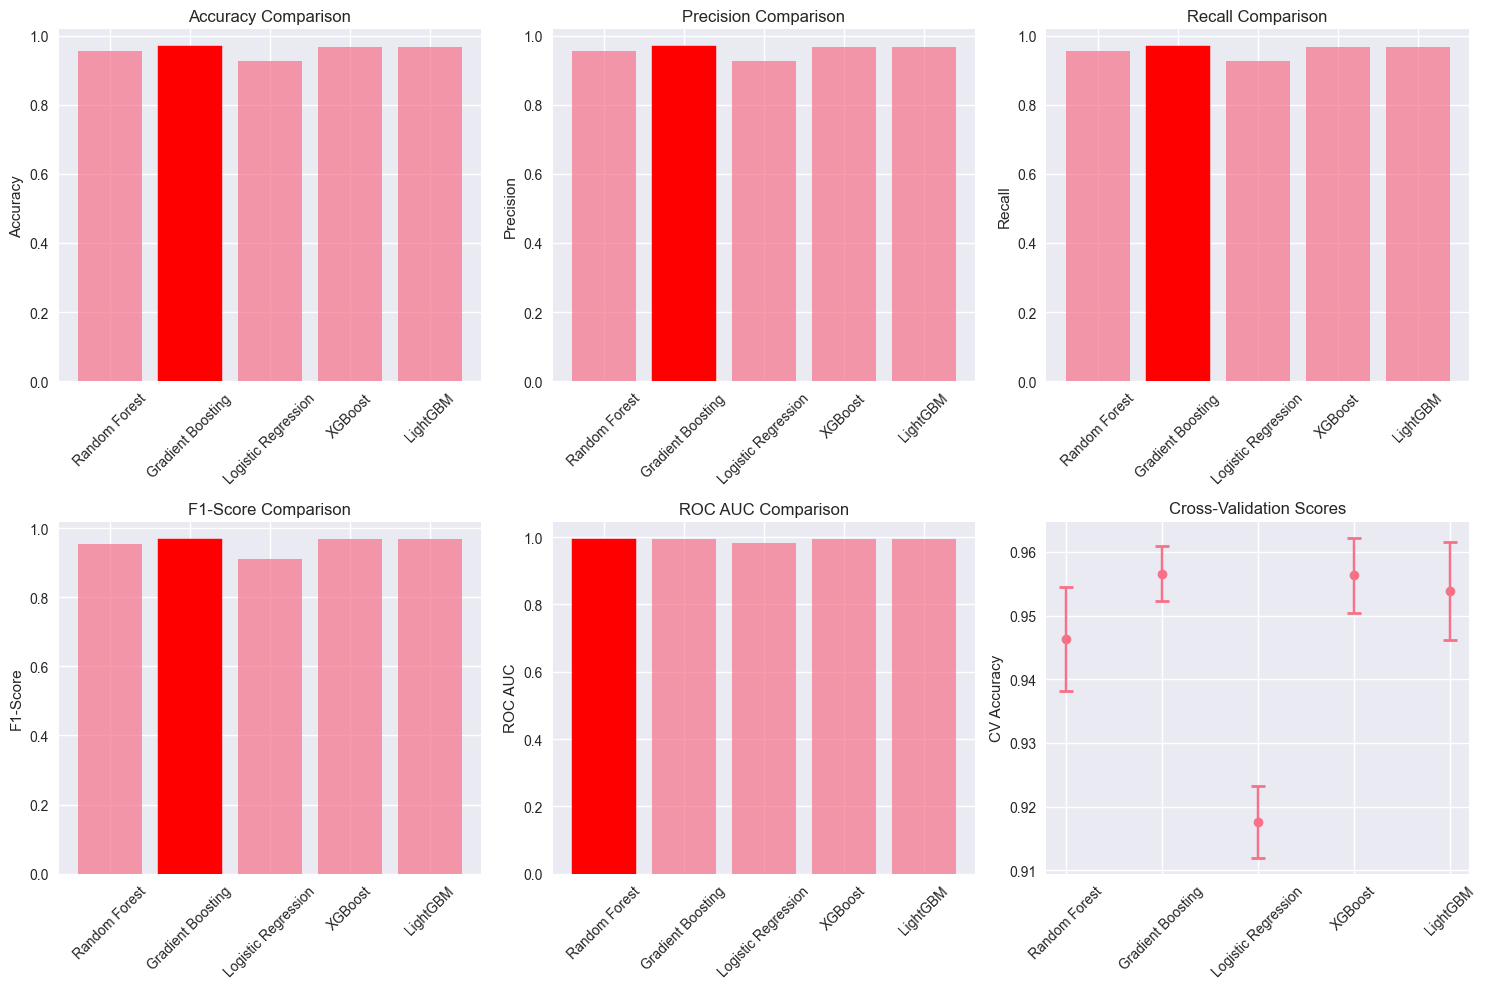

In [31]:
# Compare model performances
comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'cv_mean', 'cv_std']]
comparison_df = comparison_df.round(4)

print("=== Model Performance Comparison ===")
print(comparison_df)

# Determine best model
best_model_name = comparison_df['f1_score'].idxmax()
best_score = comparison_df.loc[best_model_name, 'f1_score']
print(f"\nBest model: {best_model_name} (F1-Score: {best_score:.4f})")

# Performance chart
plt.figure(figsize=(15, 10))

# Metric comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names), 1):
    plt.subplot(2, 3, i)
    bars = plt.bar(comparison_df.index, comparison_df[metric], alpha=0.7)
    plt.title(f'{metric_name} Comparison')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    
    # Highlight best model
    best_idx = comparison_df[metric].idxmax()
    for j, bar in enumerate(bars):
        if comparison_df.index[j] == best_idx:
            bar.set_color('red')
            bar.set_alpha(1.0)

# CV score comparison
plt.subplot(2, 3, 6)
plt.errorbar(range(len(comparison_df)), comparison_df['cv_mean'], 
            yerr=comparison_df['cv_std'], fmt='o', capsize=5, capthick=2)
plt.xticks(range(len(comparison_df)), comparison_df.index, rotation=45)
plt.title('Cross-Validation Scores')
plt.ylabel('CV Accuracy')

plt.tight_layout()
plt.show()

=== Gradient Boosting Detailed Analysis ===

Classification Report:
                precision    recall  f1-score   support

     Candidate       0.94      0.97      0.96       275
     Confirmed       0.99      0.99      0.99       463
False_Positive       0.91      0.79      0.85        63

      accuracy                           0.97       801
     macro avg       0.95      0.92      0.93       801
  weighted avg       0.97      0.97      0.97       801



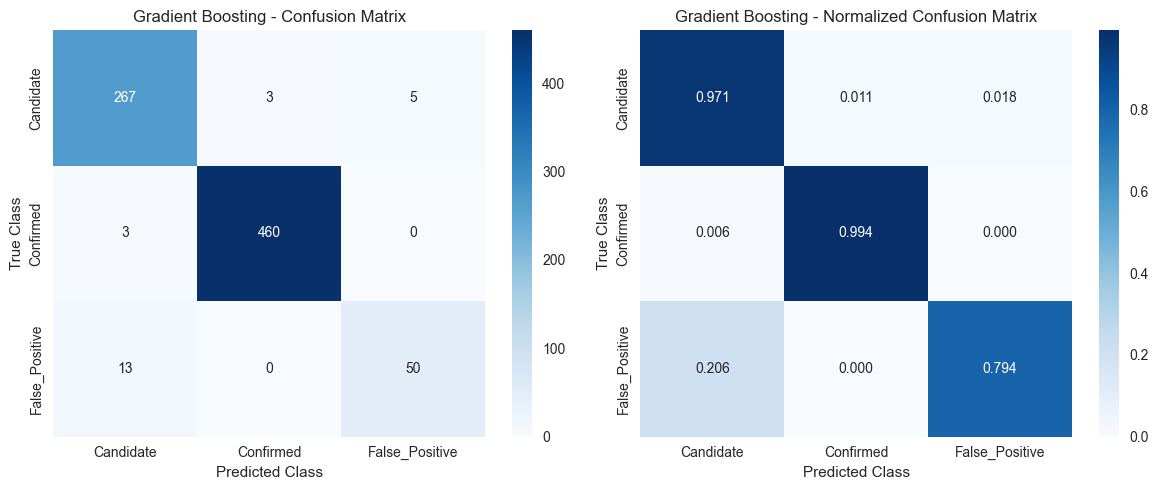


Class-wise Performance:
Candidate: 0.9709 accuracy (275 samples)
Confirmed: 0.9935 accuracy (463 samples)
False_Positive: 0.7937 accuracy (63 samples)


In [32]:
# Detailed analysis of best model
print(f"=== {best_model_name} Detailed Analysis ===")

best_model = trained_models[best_model_name]
best_predictions = results[best_model_name]['predictions']

# Classification report
target_names = ['Candidate', 'Confirmed', 'False_Positive']
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=target_names, yticklabels=target_names)
plt.title(f'{best_model_name} - Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Normalized Confusion Matrix
plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
           xticklabels=target_names, yticklabels=target_names)
plt.title(f'{best_model_name} - Normalized Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.tight_layout()
plt.show()

# Class-wise performance
print("\nClass-wise Performance:")
for i, class_name in enumerate(target_names):
    class_mask = y_test == i
    if class_mask.sum() > 0:
        class_predictions = best_predictions[class_mask]
        class_accuracy = (class_predictions == i).sum() / len(class_predictions)
        print(f"{class_name}: {class_accuracy:.4f} accuracy ({class_mask.sum()} samples)")

## 8. Feature Importance Analysis

=== Feature Importance Analysis ===

Random Forest - Top 10 Most Important Features:
           Feature  Importance
1          sy_pnum    0.535601
19       pl_nnotes    0.063243
10          sy_plx    0.041930
3       pl_tranmid    0.041507
2          pl_rade    0.035296
9      sy_disterr1    0.035287
18  sy_gaiamagerr1    0.033861
6              dec    0.026563
8          sy_dist    0.025427
4        pl_ratror    0.023838

Gradient Boosting - Top 10 Most Important Features:
           Feature  Importance
1          sy_pnum    0.730337
3       pl_tranmid    0.091870
18  sy_gaiamagerr1    0.028385
4        pl_ratror    0.023498
7            sy_pm    0.016558
2          pl_rade    0.013440
5           st_rad    0.010674
9      sy_disterr1    0.010232
11         sy_bmag    0.009970
19       pl_nnotes    0.009744

XGBoost - Top 10 Most Important Features:
           Feature  Importance
1          sy_pnum    0.786781
3       pl_tranmid    0.031033
4        pl_ratror    0.018163
19       pl_n

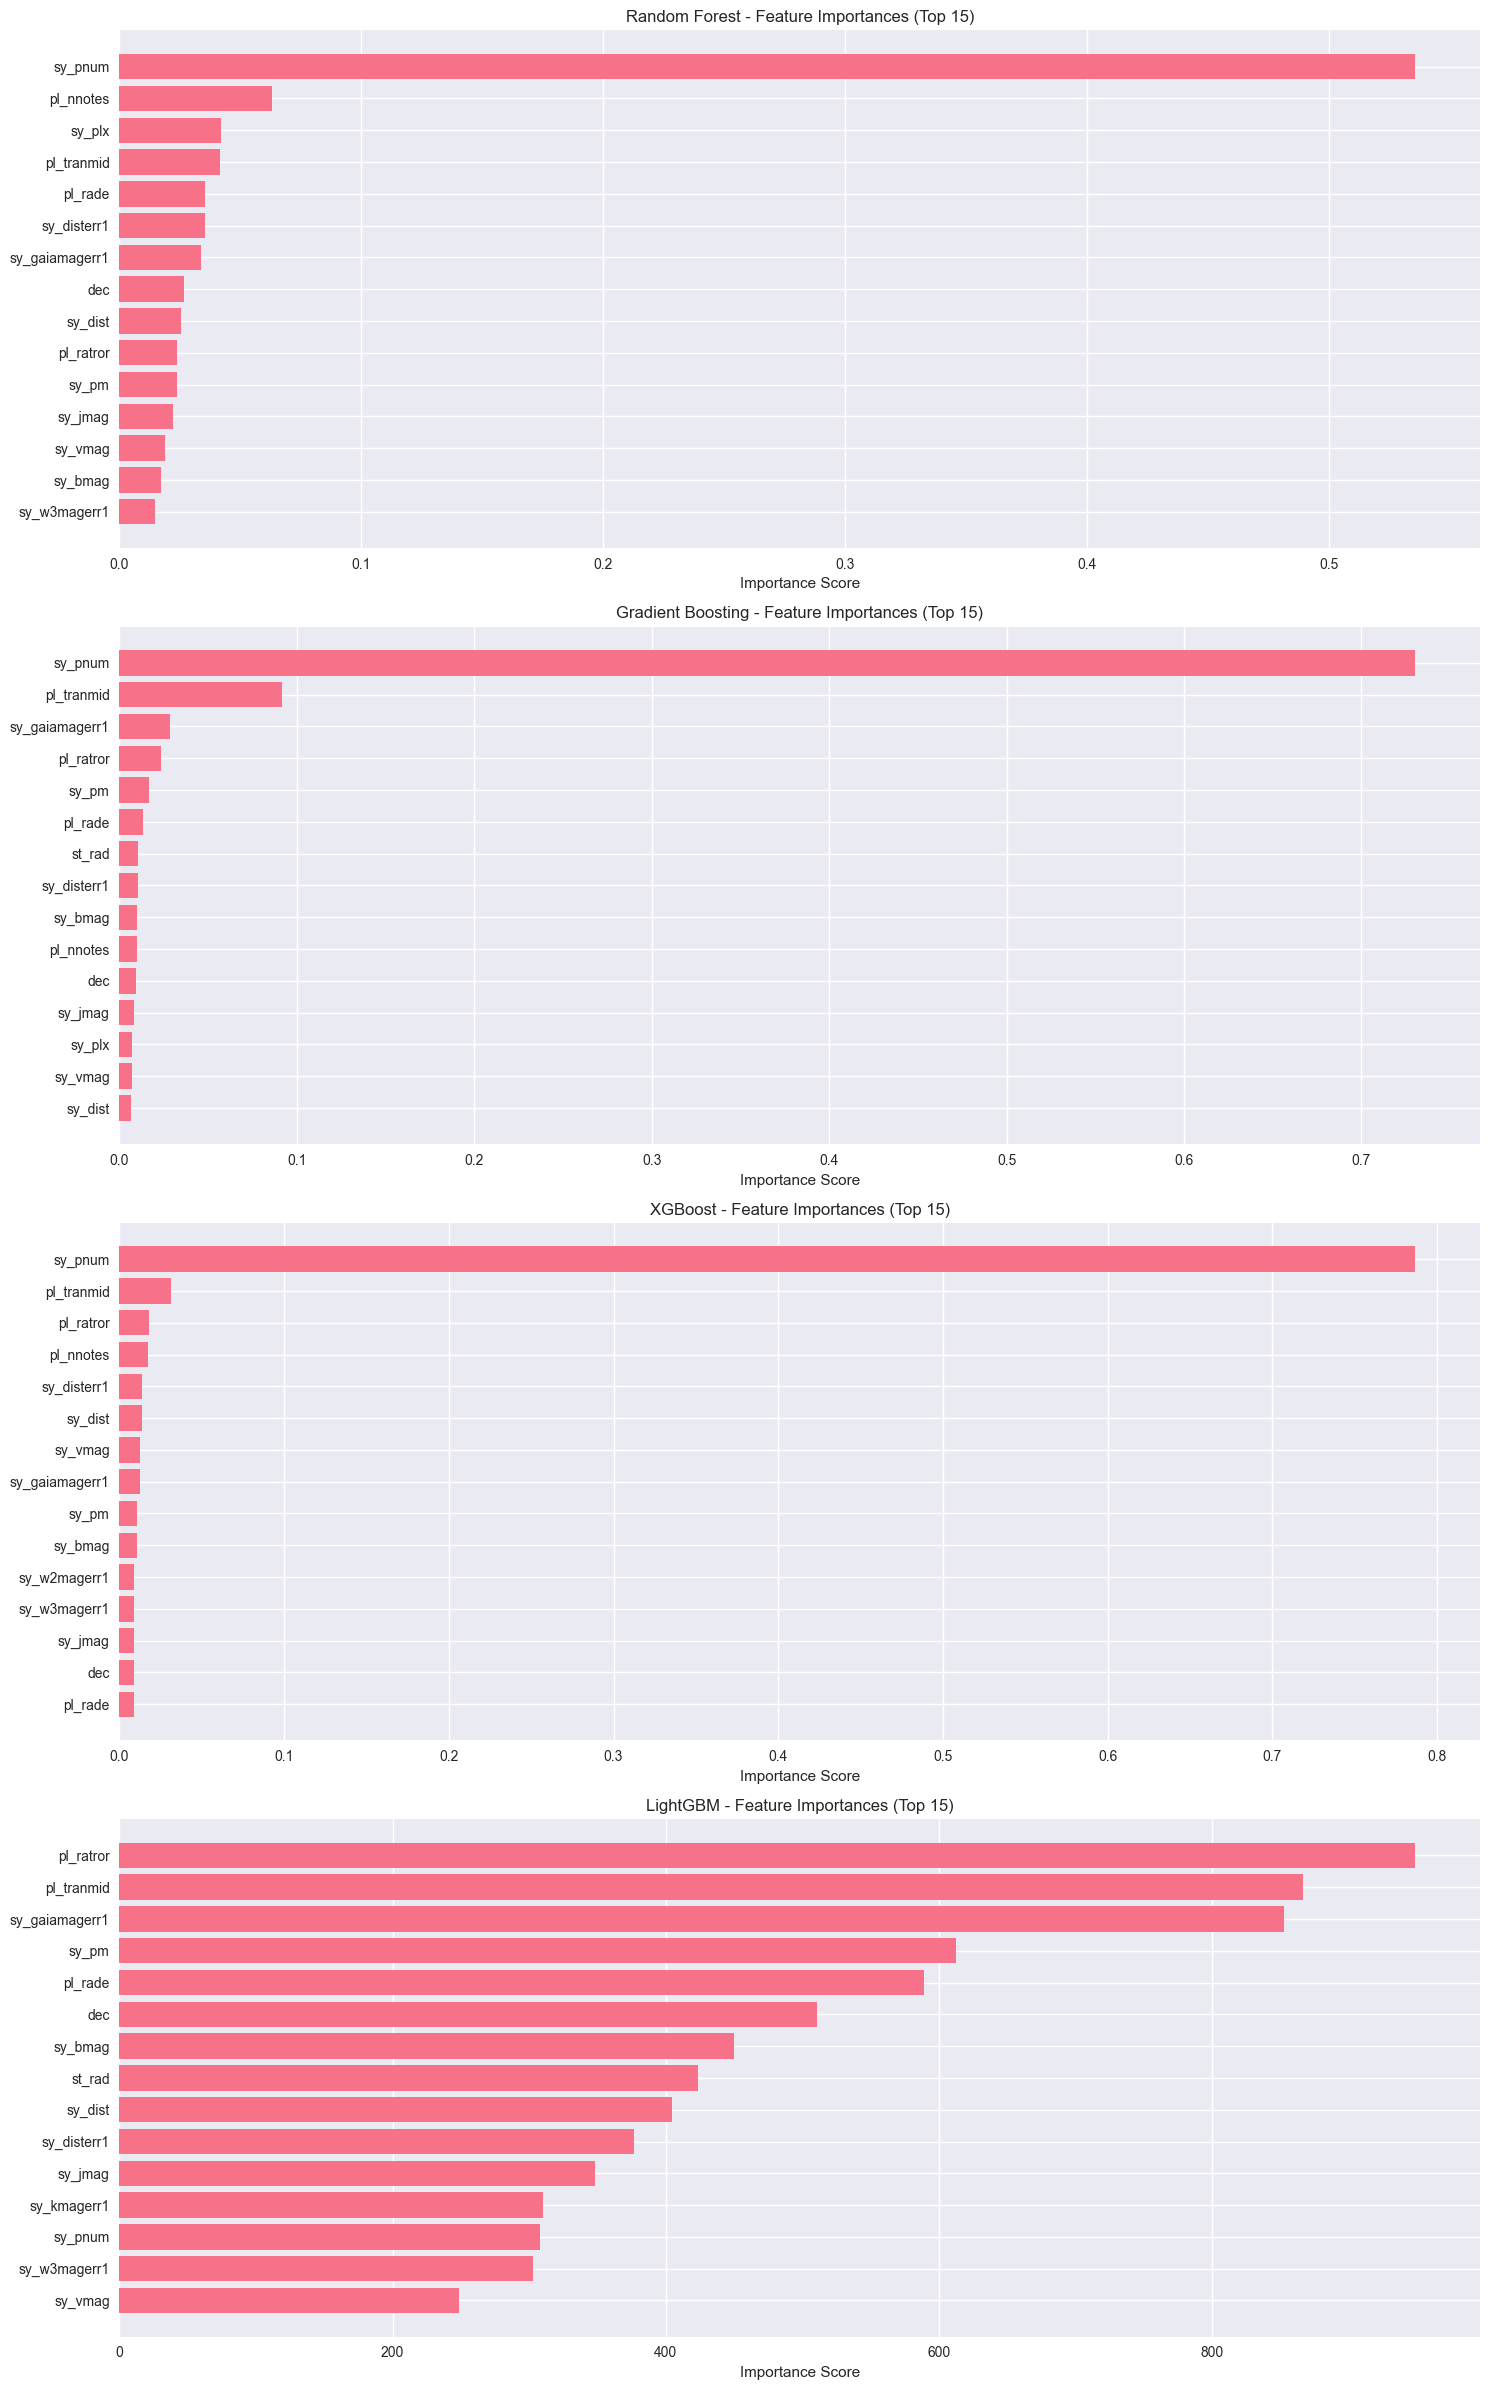

In [33]:
# Feature importance analysis (only for tree-based models)
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
available_tree_models = [name for name in tree_based_models if name in trained_models]

if len(available_tree_models) > 0:
    print("=== Feature Importance Analysis ===")
    
    plt.figure(figsize=(15, 6 * len(available_tree_models)))
    
    for i, model_name in enumerate(available_tree_models, 1):
        model = trained_models[model_name]
        
        # Get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # Create feature importance DataFrame
            importance_df = pd.DataFrame({
                'Feature': X_train_scaled.columns,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print(f"\n{model_name} - Top 10 Most Important Features:")
            print(importance_df.head(10))
            
            # Plot
            plt.subplot(len(available_tree_models), 1, i)
            top_features = importance_df.head(15)
            plt.barh(range(len(top_features)), top_features['Importance'])
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Importance Score')
            plt.title(f'{model_name} - Feature Importances (Top 15)')
            plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("No tree-based models found.")

## 9. Model Optimization (Hyperparameter Tuning)

In [34]:
# Optimize the best model
print(f"=== {best_model_name} Optimization ===")

# Define parameter grid based on model type
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_samples_split': [5, 10]
    },
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

if XGBOOST_AVAILABLE:
    param_grids['XGBoost'] = {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_child_weight': [1, 3]
    }

if LIGHTGBM_AVAILABLE:
    param_grids['LightGBM'] = {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_child_samples': [10, 20]
    }

# Perform Grid Search
if best_model_name in param_grids:
    print(f"Starting Grid Search for {best_model_name}...")
    
    base_model = models[best_model_name]
    param_grid = param_grids[best_model_name]
    
    # Use Stratified K-Fold
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=cv, 
        scoring='f1_weighted',
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Test optimized model
    optimized_model = grid_search.best_estimator_
    y_pred_optimized = optimized_model.predict(X_test_scaled)
    
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    optimized_f1 = f1_score(y_test, y_pred_optimized, average='weighted')
    
    print(f"\nOptimized model performance:")
    print(f"Test Accuracy: {optimized_accuracy:.4f}")
    print(f"Test F1-Score: {optimized_f1:.4f}")
    
    print(f"\nPerformance improvement:")
    print(f"Accuracy: {optimized_accuracy - results[best_model_name]['accuracy']:.4f}")
    print(f"F1-Score: {optimized_f1 - results[best_model_name]['f1_score']:.4f}")
    
    # Update best model
    final_model = optimized_model
    
else:
    print(f"Parameter grid not defined for {best_model_name}.")
    final_model = trained_models[best_model_name]

=== Gradient Boosting Optimization ===
Starting Grid Search for Gradient Boosting...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.15, 'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 150}
Best CV score: 0.9518

Optimized model performance:
Test Accuracy: 0.9700
Test F1-Score: 0.9695

Performance improvement:
Accuracy: 0.0000
F1-Score: 0.0000
Best parameters: {'learning_rate': 0.15, 'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 150}
Best CV score: 0.9518

Optimized model performance:
Test Accuracy: 0.9700
Test F1-Score: 0.9695

Performance improvement:
Accuracy: 0.0000
F1-Score: 0.0000


## 10. Model Saving and Results

In [35]:
# Save model and preprocessing tools
import joblib
import os

# Create save directory
save_dir = "k2_results"
os.makedirs(save_dir, exist_ok=True)

print("=== Saving Models and Tools ===")

# Save final model
model_path = os.path.join(save_dir, f"k2_final_model_{best_model_name.lower().replace(' ', '_')}.joblib")
joblib.dump(final_model, model_path)
print(f"Model saved: {model_path}")

# Save scaler
scaler_path = os.path.join(save_dir, "k2_scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

# Save feature selector
selector_path = os.path.join(save_dir, "k2_feature_selector.joblib")
joblib.dump(selector, selector_path)
print(f"Feature selector saved: {selector_path}")

# Save selected features
features_path = os.path.join(save_dir, "k2_selected_features.joblib")
joblib.dump(selected_features, features_path)
print(f"Selected features saved: {features_path}")

# Save model performance
results_path = os.path.join(save_dir, "k2_model_results.joblib")
joblib.dump(results, results_path)
print(f"Model results saved: {results_path}")

print(f"\nAll files saved to '{save_dir}' directory.")

=== Saving Models and Tools ===
Model saved: k2_results\k2_final_model_gradient_boosting.joblib
Scaler saved: k2_results\k2_scaler.joblib
Feature selector saved: k2_results\k2_feature_selector.joblib
Selected features saved: k2_results\k2_selected_features.joblib
Model results saved: k2_results\k2_model_results.joblib

All files saved to 'k2_results' directory.


In [36]:
# Sample prediction function
def predict_exoplanet(model, scaler, features, input_data):
    """
    Makes exoplanet prediction for new data
    
    Parameters:
    - model: Trained model
    - scaler: Feature scaler
    - features: List of selected features
    - input_data: Input data in dict format
    
    Returns:
    - prediction: Prediction (0: Candidate, 1: Confirmed, 2: False_Positive)
    - probability: Prediction probabilities
    """
    
    # Convert input data to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Get only selected features
    input_selected = input_df[features]
    
    # Fill missing values (with median)
    input_filled = input_selected.fillna(input_selected.median())
    
    # Scale
    input_scaled = scaler.transform(input_filled)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    probability = model.predict_proba(input_scaled)[0]
    
    return prediction, probability

# Sample usage
print("=== Sample Prediction ===")
if len(X_test) > 0:
    # Take a random sample from test set
    sample_idx = X_test.index[0]
    sample_data = X_test.loc[sample_idx].to_dict()
    actual_class = y_test.loc[sample_idx]
    
    # Make prediction
    pred_class, pred_proba = predict_exoplanet(final_model, scaler, selected_features, sample_data)
    
    class_names = ['Candidate', 'Confirmed', 'False_Positive']
    
    print(f"True class: {class_names[actual_class]}")
    print(f"Predicted class: {class_names[pred_class]}")
    print("Prediction probabilities:")
    for i, (class_name, prob) in enumerate(zip(class_names, pred_proba)):
        print(f"  {class_name}: {prob:.4f}")
    
    print(f"Prediction correct: {'✓' if pred_class == actual_class else '✗'}")

=== Sample Prediction ===
True class: Confirmed
Predicted class: Confirmed
Prediction probabilities:
  Candidate: 0.0001
  Confirmed: 0.9999
  False_Positive: 0.0000
Prediction correct: ✓


In [37]:
# Project summary and results
print("="*60)
print("           K2 EXOPLANET DETECTION PROJECT")
print("           Machine Learning Pipeline v6")
print("="*60)

print(f"\n📊 DATASET INFORMATION:")
print(f"   • Total sample count: {len(df_clean):,}")
print(f"   • Number of features used: {len(selected_features)}")
print(f"   • Number of classes: 3 (Candidate, Confirmed, False_Positive)")

print(f"\n🎯 CLASS DISTRIBUTION:")
for i, class_name in enumerate(['Candidate', 'Confirmed', 'False_Positive']):
    count = (y == i).sum()
    percentage = (count / len(y)) * 100
    print(f"   • {class_name}: {count:,} ({percentage:.1f}%)")

print(f"\n🤖 MODEL RESULTS:")
print(f"   • Number of trained models: {len(trained_models)}")
print(f"   • Best model: {best_model_name}")
print(f"   • Test accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   • F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"   • ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

print(f"\n📁 SAVED FILES:")
print(f"   • Model: {save_dir}/k2_final_model_*.joblib")
print(f"   • Scaler: {save_dir}/k2_scaler.joblib")
print(f"   • Feature Selector: {save_dir}/k2_feature_selector.joblib")
print(f"   • Selected Features: {save_dir}/k2_selected_features.joblib")

print(f"\n🔬 IMPORTANT FEATURES (Top 5):")
if 'Random Forest' in trained_models and hasattr(trained_models['Random Forest'], 'feature_importances_'):
    rf_importances = trained_models['Random Forest'].feature_importances_
    top_features_idx = np.argsort(rf_importances)[-5:][::-1]
    for i, idx in enumerate(top_features_idx, 1):
        feature_name = selected_features[idx]
        importance = rf_importances[idx]
        print(f"   {i}. {feature_name}: {importance:.4f}")

print(f"\n✅ PIPELINE COMPLETED!")
print("   This model can be used for exoplanet detection from K2 data.")
print("="*60)

           K2 EXOPLANET DETECTION PROJECT
           Machine Learning Pipeline v6

📊 DATASET INFORMATION:
   • Total sample count: 4,004
   • Number of features used: 20
   • Number of classes: 3 (Candidate, Confirmed, False_Positive)

🎯 CLASS DISTRIBUTION:
   • Candidate: 1,374 (34.3%)
   • Confirmed: 2,315 (57.8%)
   • False_Positive: 315 (7.9%)

🤖 MODEL RESULTS:
   • Number of trained models: 5
   • Best model: Gradient Boosting
   • Test accuracy: 0.9700
   • F1-Score: 0.9695
   • ROC AUC: 0.9932

📁 SAVED FILES:
   • Model: k2_results/k2_final_model_*.joblib
   • Scaler: k2_results/k2_scaler.joblib
   • Feature Selector: k2_results/k2_feature_selector.joblib
   • Selected Features: k2_results/k2_selected_features.joblib

🔬 IMPORTANT FEATURES (Top 5):
   1. sy_pnum: 0.5356
   2. pl_nnotes: 0.0632
   3. sy_plx: 0.0419
   4. pl_tranmid: 0.0415
   5. pl_rade: 0.0353

✅ PIPELINE COMPLETED!
   This model can be used for exoplanet detection from K2 data.
